In [18]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 120)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [2]:
def read_df_fbref(path, sep):
    
    df= pd.read_csv(path, sep= sep)
    df.columns= df.iloc[0]
    df.drop([0], inplace= True)
    df.reset_index(drop= True, inplace= True)
    
    return df

In [3]:
laliga_raw_data= pd.read_csv('./data/laliga_data_2020_2021.txt', sep=',')
laliga_raw_data.head(5)

,Rk,Squad,MP,W,D,L,GF,GA,GDiff,Pts,xG,xGA,xGDiff,xGDiff/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Atlético Madrid,18,15,2,1,36,8,28,47,24.4,13.6,10.8,0.60,W W W W W,NaN,Luis Suárez - 12,Jan Oblak,NaN
1,2,Real Madrid,19,12,4,3,34,16,18,40,30.8,20.4,10.5,0.55,W D W D W,NaN,Karim Benzema - 10,Thibaut Courtois,NaN
2,3,Barcelona,19,11,4,4,39,17,22,37,41.6,21.6,19.9,1.05,D W W W W,NaN,Lionel Messi - 11,Marc-André ter Stegen,NaN
3,4,Sevilla,19,11,3,5,26,16,10,36,25.1,18.5,6.6,0.35,D W L W W,NaN,Youssef En-Nesyri - 12,Yassine Bounou,NaN
4,5,Villarreal,20,8,10,2,28,19,9,34,29.6,16.7,12.9,0.64,L W W D D,NaN,Gerard Moreno - 10,Sergio Asenjo,NaN


In [4]:
laliga_gk_stats= read_df_fbref('./data/stats_advanced_gk.txt', ',')
laliga_gk_stats.head(5)

,Squad,# Pl,90s,GA,PKA,FK,CK,OG,PSxG,PSxG/SoT,PSxG+/-,/90,Cmp,Att,Cmp%,Att,Thr,Launch%,AvgLen,Att,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,Alavés,1,20.0,29,1,0,4,0,27.9,0.34,-1.1,-0.05,191,368,51.9,425,59,61.4,45.5,169,63.3,47.2,178,16,9.0,15,0.75,15.1
1,Athletic Club,1,18.0,22,3,0,4,1,17.6,0.31,-3.4,-0.19,147,339,43.4,457,85,50.5,42.7,124,87.1,64.6,169,11,6.5,13,0.72,14.1
2,Atlético Madrid,1,18.0,8,1,0,2,2,11.9,0.21,+5.9,+0.33,133,307,43.3,342,53,58.8,43.9,157,67.5,49.4,168,10,6.0,5,0.28,13.9
3,Barcelona,2,19.0,17,2,0,4,0,20.5,0.27,+3.5,+0.18,90,145,62.1,507,102,21.7,28.7,110,31.8,32.1,125,12,9.6,13,0.68,16.4
4,Betis,2,20.0,34,5,0,7,2,33.3,0.41,+1.3,+0.06,136,354,38.4,532,78,53.2,43.0,124,57.3,46.3,150,8,5.3,12,0.60,15.3


In [5]:
laliga_xg_xga= laliga_raw_data.loc[:,['Squad','MP','Pts', 'GF', 'GA', 'xG', 'xGA']]

In [6]:
laliga_xg_xga['GF_per90']= round(laliga_xg_xga['GF']/laliga_xg_xga['MP'],2)
laliga_xg_xga['GA_per90']= round(laliga_xg_xga['GA']/laliga_xg_xga['MP'],2)
laliga_xg_xga['xG_per90']= round(laliga_xg_xga['xG']/laliga_xg_xga['MP'],2)
laliga_xg_xga['xGA_per90']= round(laliga_xg_xga['xGA']/laliga_xg_xga['MP'],2)

In [7]:
laliga_stats= laliga_xg_xga.merge(laliga_gk_stats[['Squad', 'PSxG']], how= 'inner', on= 'Squad')

In [8]:
laliga_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Squad      20 non-null     object 
 1   MP         20 non-null     int64  
 2   Pts        20 non-null     int64  
 3   GF         20 non-null     int64  
 4   GA         20 non-null     int64  
 5   xG         20 non-null     float64
 6   xGA        20 non-null     float64
 7   GF_per90   20 non-null     float64
 8   GA_per90   20 non-null     float64
 9   xG_per90   20 non-null     float64
 10  xGA_per90  20 non-null     float64
 11  PSxG       20 non-null     object 
dtypes: float64(6), int64(4), object(2)
memory usage: 2.0+ KB


In [9]:
laliga_stats['PSxG']= laliga_stats['PSxG'].apply(lambda x: float(x))
laliga_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Squad      20 non-null     object 
 1   MP         20 non-null     int64  
 2   Pts        20 non-null     int64  
 3   GF         20 non-null     int64  
 4   GA         20 non-null     int64  
 5   xG         20 non-null     float64
 6   xGA        20 non-null     float64
 7   GF_per90   20 non-null     float64
 8   GA_per90   20 non-null     float64
 9   xG_per90   20 non-null     float64
 10  xGA_per90  20 non-null     float64
 11  PSxG       20 non-null     float64
dtypes: float64(7), int64(4), object(1)
memory usage: 2.0+ KB


In [10]:
xGpg_avg = laliga_stats['xG_per90'].mean()
xGApg_avg = laliga_stats['xGA_per90'].mean()
Gpg_avg = laliga_stats['GF_per90'].mean()
GApg_avg = laliga_stats['GA_per90'].mean()

In [11]:
def status_xG_xGA(df):
    
    conditions= [(laliga_stats['xG_per90'] < xGpg_avg) & (laliga_stats['xGA_per90'] > xGApg_avg),
                (laliga_stats['xG_per90'] > xGpg_avg) & (laliga_stats['xGA_per90'] > xGApg_avg),
                (laliga_stats['xG_per90'] < xGpg_avg) & (laliga_stats['xGA_per90'] < xGApg_avg),
                (laliga_stats['xG_per90'] > xGpg_avg) & (laliga_stats['xGA_per90'] < xGApg_avg)]
    values= ['Bad xG | Bad xGA', 'Good xG | Bad xGA', 
             'Bad xG | Good xGA' , 'Good xG | Good xGA']
    
    df['Status_xG_xGA']= np.select(conditions, values)
    
    return df

def status_GF_GA(df):
    
    conditions= [(laliga_stats['GF_per90'] < Gpg_avg) & (laliga_stats['GA_per90'] > GApg_avg),
                (laliga_stats['GF_per90'] > Gpg_avg) & (laliga_stats['GA_per90'] > GApg_avg),
                (laliga_stats['GF_per90'] < Gpg_avg) & (laliga_stats['GA_per90'] < GApg_avg),
                (laliga_stats['GF_per90'] > Gpg_avg) & (laliga_stats['GA_per90'] < GApg_avg)]
    values= ['Bad Attack | Bad Defense', 'Good Attack | Bad Defense', 
             'Bad Attack | Good Defense' , 'Good Attack | Good Defense']
    
    df['Status_GF_GA']= np.select(conditions, values)
    
    return df

In [12]:
status_xG_xGA(laliga_stats).sample(5)

,Squad,MP,Pts,GF,GA,xG,xGA,GF_per90,GA_per90,xG_per90,xGA_per90,PSxG,Status_xG_xGA
8,Celta Vigo,20,24,24,31,27.6,22.8,1.2,1.55,1.38,1.14,27.3,Good xG | Good xGA
6,Granada,20,28,24,34,20.7,28.5,1.2,1.70,1.03,1.42,32.6,Bad xG | Bad xGA
13,Valencia,20,20,26,29,22.6,30.2,1.3,1.45,1.13,1.51,29.9,Bad xG | Bad xGA
0,Atlético Madrid,18,47,36,8,24.4,13.6,2.0,0.44,1.36,0.76,11.9,Good xG | Good xGA
4,Villarreal,20,34,28,19,29.6,16.7,1.4,0.95,1.48,0.84,15.2,Good xG | Good xGA


In [13]:
status_GF_GA(laliga_stats).sample(5)

,Squad,MP,Pts,GF,GA,xG,xGA,GF_per90,GA_per90,xG_per90,xGA_per90,PSxG,Status_xG_xGA,Status_GF_GA
3,Sevilla,19,36,26,16,25.1,18.5,1.37,0.84,1.32,0.97,14.5,Good xG | Good xGA,Good Attack | Good Defense
17,Alavés,20,18,18,29,22.9,28.6,0.90,1.45,1.14,1.43,27.9,Bad xG | Bad xGA,Bad Attack | Bad Defense
2,Barcelona,19,37,39,17,41.6,21.6,2.05,0.89,2.19,1.14,20.5,Good xG | Good xGA,Good Attack | Good Defense
18,Elche,18,17,16,25,13.1,30.3,0.89,1.39,0.73,1.68,27.0,Bad xG | Bad xGA,Bad Attack | Bad Defense
0,Atlético Madrid,18,47,36,8,24.4,13.6,2.00,0.44,1.36,0.76,11.9,Good xG | Good xGA,Good Attack | Good Defense


In [14]:
laliga_stats['GF-xG']= laliga_stats['GF']-laliga_stats['xG']
laliga_stats['xGA-GA']= laliga_stats['xGA']-laliga_stats['GA']
laliga_stats['PsxG-GA']= laliga_stats['PSxG']-laliga_stats['GA']

In [15]:
laliga_stats['Posicion']= np.arange(1,21)
laliga_stats.columns.values

array(['Squad', 'MP', 'Pts', 'GF', 'GA', 'xG', 'xGA', 'GF_per90',
       'GA_per90', 'xG_per90', 'xGA_per90', 'PSxG', 'Status_xG_xGA',
       'Status_GF_GA', 'GF-xG', 'xGA-GA', 'PsxG-GA', 'Posicion'],
      dtype=object)

In [16]:
columns= ['Squad', 'Posicion', 'MP', 'Pts', 'GF', 'GA', 'xG', 'xGA', 'PSxG', 'GF_per90',
       'GA_per90', 'xG_per90', 'xGA_per90', 'Status_xG_xGA',
       'Status_GF_GA', 'GF-xG', 'xGA-GA', 'PsxG-GA']

laliga_stats= laliga_stats[columns]
laliga_stats.head(5)

,Squad,Posicion,MP,Pts,GF,GA,xG,xGA,PSxG,GF_per90,GA_per90,xG_per90,xGA_per90,Status_xG_xGA,Status_GF_GA,GF-xG,xGA-GA,PsxG-GA
0,Atlético Madrid,1,18,47,36,8,24.4,13.6,11.9,2.00,0.44,1.36,0.76,Good xG | Good xGA,Good Attack | Good Defense,11.6,5.6,3.9
1,Real Madrid,2,19,40,34,16,30.8,20.4,15.5,1.79,0.84,1.62,1.07,Good xG | Good xGA,Good Attack | Good Defense,3.2,4.4,-0.5
2,Barcelona,3,19,37,39,17,41.6,21.6,20.5,2.05,0.89,2.19,1.14,Good xG | Good xGA,Good Attack | Good Defense,-2.6,4.6,3.5
3,Sevilla,4,19,36,26,16,25.1,18.5,14.5,1.37,0.84,1.32,0.97,Good xG | Good xGA,Good Attack | Good Defense,0.9,2.5,-1.5
4,Villarreal,5,20,34,28,19,29.6,16.7,15.2,1.40,0.95,1.48,0.84,Good xG | Good xGA,Good Attack | Good Defense,-1.6,-2.3,-3.8


In [73]:
laliga_clusters = laliga_stats.iloc[:,4:9]

In [76]:
def exec_kmeans(k, df):
    
    X = StandardScaler().fit_transform(df)
    
    kmean = KMeans(n_clusters= k, random_state= 42)
    y_pred = kmean.fit_predict(X)
    
    df['Cluster'] = y_pred
    
    plt.figure(figsize= (16, 6))
    cls = ['red', 'green', 'blue', 'yellow', 'black']
    assign = []
    
    for i in y_pred:
        assign.append(cls[i])
        
    plt.scatter(X[:,0], X[:,1], c= assign, s= 70)
    
    plt.show()
    
    return df

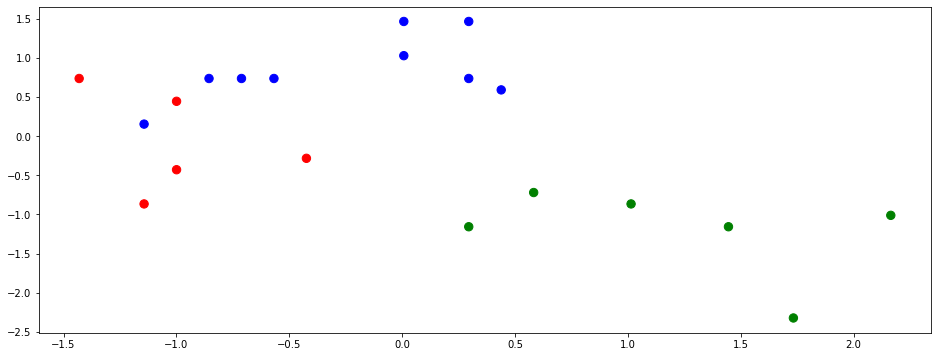

,GF,GA,xG,xGA,PSxG,Cluster
0,36,8,24.4,13.6,11.9,1
1,34,16,30.8,20.4,15.5,1
2,39,17,41.6,21.6,20.5,1
3,26,16,25.1,18.5,14.5,1
4,28,19,29.6,16.7,15.2,1
5,31,18,32.4,18.0,16.3,1
6,24,34,20.7,28.5,32.6,2
7,26,34,23.7,28.9,33.3,2
8,24,31,27.6,22.8,27.3,2
9,17,27,18.1,22.1,21.7,0


In [84]:
exec_kmeans(3, laliga_clusters)

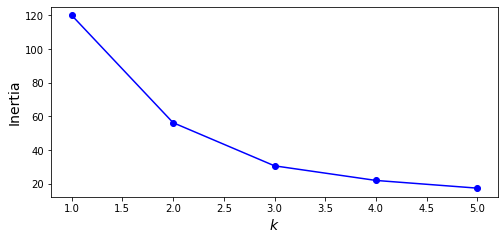

In [78]:
X = StandardScaler().fit_transform(laliga_clusters)

kmeans_per_k = [KMeans(n_clusters= k, random_state= 42).fit(X) for k in range(1,6)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 6), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

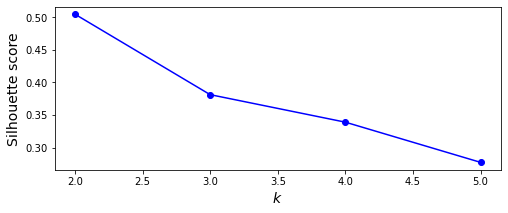

In [83]:
silhouette_scores = [silhouette_score(laliga_clusters, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 6), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

In [69]:
fig = px.scatter(laliga_stats, x= 'xG_per90', y='xGA_per90', size= 'Pts', color= 'Squad', 
                facet_col= 'Status_xG_xGA', opacity= 1, hover_name= 'Squad', hover_data= ['Posicion'], 
                color_discrete_sequence=px.colors.qualitative.Dark24,
                width= 950, template= 'seaborn',                
                category_orders= {'Status_xG_xGA': ['Good xG | Good xGA', 'Good xG | Bad xGA',
                                                    'Bad xG | Good xGA', 'Bad xG | Bad xGA']},
                title= '<b>Quality of Shots Taken (xG) vs Quality of Shots Conceded (xGA)</b><br>La Liga 2020-2021 (Fixtures 1-20)')

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(title={'y': 0.95,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  title_font= dict(size=25))

fig.update_yaxes(autorange="reversed")

fig.show()

In [70]:
fig = px.scatter(laliga_stats, x= 'GF_per90', y='GA_per90', size= 'Pts', color= 'Squad', 
                facet_col= 'Status_GF_GA', opacity= 1, hover_name= 'Squad', hover_data= ['Posicion'],
                color_discrete_sequence=px.colors.qualitative.Dark24,
                width= 950, template= 'seaborn',                
                category_orders= {'Status_GF_GA': ['Good Attack | Good Defense', 'Good Attack | Bad Defense',
                                                   'Bad Attack | Good Defense', 'Bad Attack | Bad Defense']},
                title= '<b>Goals vs Goals Against</b><br>La Liga 2020-2021 (Fixtures 1-20)')

fig.for_each_annotation(lambda a: a.update(text= a.text.split('=')[1]))
fig.update_layout(title={'y': 0.95,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  title_font= dict(size=25))

fig.update_yaxes(autorange="reversed")

fig.show()

<h2><center>ANÁLISIS PLOTS</center></h2>
<h3><center>xG vs xGA & Goals vs Goals Against</center></h3>

-  

In [71]:
fig = px.scatter(laliga_stats, x= 'GF', y='GF-xG', size= 'Pts', color= 'Squad', 
                opacity= 1, hover_name= 'Squad', hover_data= ['Posicion'],
                color_discrete_sequence=px.colors.qualitative.Dark24,
                width= 950, template= 'seaborn', 
                title= '<b>Goals vs Goals Against</b><br>La Liga 2020-2021 (Fixtures 1-20)')

fig.add_hline(y=0, line_width=2, line_color= 'black', opacity= 0.8)
fig.add_vline(x= laliga_stats['GF'].mean(), line_width=2, line_color= 'black', opacity= 0.8)
fig.add_shape(type='rect', x0= 10, y0= -8, 
              x1=laliga_stats['GF'].mean(), y1=0, 
              fillcolor= 'red', opacity= 0.2)
fig.add_shape(type='rect', x0= laliga_stats['GF'].mean(), y0= -8, 
              x1= 42, y1= 0, 
              fillcolor= 'yellow', opacity= 0.2)
fig.add_shape(type='rect', x0= 10, y0= 0, 
              x1= laliga_stats['GF'].mean(), y1= 14, 
              fillcolor= 'yellow', opacity= 0.2)
fig.add_shape(type='rect', x0= laliga_stats['GF'].mean(), y0= 0, 
              x1= 42, y1= 14, 
              fillcolor= 'green', opacity= 0.2)

fig.update_layout(title={'y': 0.95,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  title_font= dict(size=25))

fig.show()

In [73]:
fig = px.scatter(laliga_stats, x= 'GA', y='PsxG-GA', size= 'Pts', color= 'Squad', 
                opacity= 1, hover_name= 'Squad', hover_data= ['Posicion'],
                color_discrete_sequence=px.colors.qualitative.Dark24,
                width= 950, template= 'seaborn', 
                title= '<b>Goals vs Goals Against</b><br>La Liga 2020-2021 (Fixtures 1-20)')

fig.add_hline(y=0, line_width=2, line_color= 'black', opacity= 0.8)
fig.add_vline(x= laliga_stats['GA'].mean(), line_width=2, line_color= 'black', opacity= 0.8)
fig.add_shape(type='rect', x0= 5, y0= -7, 
              x1=laliga_stats['GA'].mean(), y1=0, 
              fillcolor= 'yellow', opacity= 0.2)
fig.add_shape(type='rect', x0= laliga_stats['GA'].mean(), y0= -7, 
              x1= 38, y1= 0, 
              fillcolor= 'red', opacity= 0.2)
fig.add_shape(type='rect', x0= 5, y0= 0, 
              x1= laliga_stats['GA'].mean(), y1= 6, 
              fillcolor= 'green', opacity= 0.2)
fig.add_shape(type='rect', x0= laliga_stats['GA'].mean(), y0= 0, 
              x1= 38, y1= 6, 
              fillcolor= 'yellow', opacity= 0.2)

fig.update_layout(title={'y': 0.95,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  title_font= dict(size=25))

fig.show()

In [13]:
#laliga_stats.to_csv('./data/laliga_stats.txt', sep=',', index= False)